
# Introduction

In this project you will leverage skills that you have learnt in the past few weeks, such as Topic Modeling, Latent Dirichlet Allocation to build a small model analyzing the content of news articles from different sources around the US.

The main learning objectives for this assignment are:
1. Use LDA topic modeling to find patterns in a realistic, noisy, unlabeled text corpus
2. Understand how topic modeling results are influenced by preprocessing and hyperparemters
3. Use dimensionality reduction and clustering algorithms to create effective visualizations of large text data

Note: At some points in the assignment, we'll format some parts of instructions in all-caps. We're not yelling! We just think they're very important details that you must take note of.  

# Installation and Imports

In [ ]:
# Mount the drive to be able to read and write files from your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Python Import Statements
import re
from typing import *
import collections
import sys
import math
import numpy as np
import csv
import spacy
from tqdm import tqdm
from os.path import exists
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Part 1: Basic Topic Model

First, let's train a basic topic model and see what happens! We'll do very basic text preprocessing (tokenization and lower casing) to start, and we'll use LSA for the topic model.

You can download the dataset [here](https://drive.google.com/file/d/1146a1rhJ95NEySuMS000KDRPcat-itPh/view?usp=sharing) - we've handled loading it below.

**Warning**: Loading the data could take as much as 10 minutes when running for the first time. After that, the parsed documents are cached in a pickle file...

In [ ]:
######################
#     LOAD DATA      #
#############################################################################################################################
# This cell block will load in the dataset into                                                                             #
#   * spacy_processed_docs - A list of Spacy Documents that we can use as data to train our Topic Model                     #
#   * doc_locations - A list of States where each Document was sourced from (This will be used in Part 3: Visualization)    #
#############################################################################################################################

num_documents = 5000 # INFO: Feel free to change this to load in less documents for debugging but otherwise keep it at 5000 to train the Topic Model
# FILEPATH = "path/to/dataset" # TODO: Update this to the filepath of your copy of the assignment, e.g. /content/drive/MyDrive/Topic Modeling/
FILEPATH = ""

nlp = spacy.load('en_core_web_sm')

doc_locations = []
spacy_processed_docs = []

if exists(f"{FILEPATH}spacy_processed_docs_{num_documents}.pkl"):
  with open(f"{FILEPATH}spacy_processed_docs_{num_documents}.pkl", 'rb') as f:
    spacy_processed_docs, doc_locations = pickle.load(f)
    f.close()
else:
  with open(f'{FILEPATH}articles_sampled_data.csv', 'r', encoding='utf-8') as f:
    for i, row in tqdm(enumerate(csv.DictReader(f, delimiter=','))):
      if i == num_documents:
        break
      if i % 500 == 0:
        print("Processing row %d"%i)
      try:
        parsed = nlp(row["content"])
        source_name = row["location"]
      except ValueError:
        continue
      spacy_processed_docs.append(parsed)
      doc_locations.append(source_name)
    f.close()

  with open(f"{FILEPATH}spacy_processed_docs_{num_documents}.pkl", 'wb') as f:
    pickle.dump((spacy_processed_docs, doc_locations), f)
    f.close()

0it [00:00, ?it/s]

Processing row 0


500it [01:07,  5.87it/s]

Processing row 500


1001it [02:09,  8.54it/s]

Processing row 1000


1502it [03:10, 11.80it/s]

Processing row 1500


2000it [04:08, 13.53it/s]

Processing row 2000


2501it [05:03,  6.90it/s]

Processing row 2500


3002it [05:57, 14.94it/s]

Processing row 3000


3502it [06:55, 11.58it/s]

Processing row 3500


4000it [07:48,  8.47it/s]

Processing row 4000


4501it [08:45,  7.21it/s]

Processing row 4500


5000it [09:45,  8.54it/s]


In [ ]:
# Run this to make sure that the data is loaded in correctly, there should be 5000 documents
print("PROCESSED")
print(spacy_processed_docs[0])
print(f"\nNumber of documents: {len(spacy_processed_docs)}")

PROCESSED
By Special to the Advance

Spain Park’s Sarah Ashlee Barker is the Alabama Sports Writers Association 33rd Miss Basketball and first from Spain Park.

The Georgia signee is also the Gatorade state Player of the Year, the MaxPreps state Player of the Year, the AL.com Player of the Year and the AL.com Birmingham Region Player of the Year.

She has been selected to the Alabama Sports Writers Association All-State team each of the past three seasons and is the two-time Class 7A Player of the Year.

Barker led the Jaguars to their second Class 7A state championship in the past three seasons, averaging 23.3 points, 10.9 rebounds and 2.7 assists this season for coach Mike Chase.

She earned Class 7A tournament MVP this season and was also named all-tournament on Spain Park’s 2018 championship team and 2017 finalist squad.

Number of documents: 5000


To start, let's build the following components for topic modeling:

1.  **M**:
    A binary term-document matrix of shape (num_documents, vocab_size)

2.  **word2idx**: A dictionary which maps each word to its rank in the vocabulary (e.g. the most frequent word should have rank 0, the second most frequent word rank 1, etc).

3.  **idx2word**: The inverse of the above (i.e., mapping from index to word)

You will use **M** to train the topic model directly, and you will use the other two lookup tables in order to analyze the actual topics produced. You should use spacy to ***TOKENIZE*** and ***LOWERCASE*** the raw text, but not do any additional preprocessing.
When lowercasing, please use `token.lemma_.lower()`

In [ ]:
def binary_term_doc_matrix(docs : List[spacy.tokens.Doc]) -> Tuple[np.ndarray[np.float64], Dict[int, str]]:
  """
  Preprocess and transform docs to create our binary term-document matrix and dictionaries as described above
  TODO: You will need to fill in word2idx and idx2word, and then M
  HINT: Make sure to use token.lemma_.lower() to lowercase text rather than token.text.lower()

  Parameters
  ----------
  docs : List[Doc]
    A list of spacy processed documents (i.e. each item is the output of nlp(article))

  Returns
  -------
  M : np.ndarray[float]
    The binary term-document matrix, each value in M should be either 0 or 1
  idx2word : Dict[int, str]
    The dictionary that maps each index/rank to each word in the vocabulary
  """
  # Create a vocabulary of unique lemmatized and lowercase words
  vocabulary = set()

  for doc in docs:
    for token in doc:
      vocabulary.add(token.lemma_.lower())

  # Create word2idx and idx2word dictionaries
  word2idx = {word: idx for idx, word in enumerate(sorted(vocabulary))}
  idx2word = {idx: word for word, idx in word2idx.items()}

  # Initialize the binary term-document matrix M
  M = np.zeros((len(docs), len(vocabulary)))

  # Fill in the binary term-document matrix M
  for doc_idx, doc in enumerate(docs):
    for token in doc:
      word = token.lemma_.lower()
      word_idx = word2idx[word]
      M[doc_idx, word_idx] = 1

  return M, idx2word

In [ ]:
# Run the function you just wrote, the shape should be (5000, 59205)
###############################################
M,idx2word = binary_term_doc_matrix(spacy_processed_docs)
print(M.shape)
###############################################

(5000, 59205)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

def train_topic_model(term_doc_mat : np.ndarray[np.float64], n_topics : int = 10, random_state = 42) -> LatentDirichletAllocation:
  """
  Train a n_topics topic model on M using Latent Dirichlet Allocation
  TODO: Use LDA to fit a model with n_topics, then return the model
  NOTE: You MUST use the given random state when intialzing your LDA model.

  Parameters
  ----------
  term_doc_mat : np.ndarray[float]
    The term-document matrix to train the LDA model on
  n_topics : int
    The number of topics in the topic model (Defaulted to 10)
  random_state : int
    The random state of the LDA Model (Defaulted to 42)

  Returns
  -------
  lda : LatentDirichletAllocation
    The trained LDA model
  """
  # Create an instance of the LDA model
  lda = LatentDirichletAllocation(n_components=n_topics, random_state=random_state)

  # Fit the LDA model to the term-document matrix
  lda.fit(term_doc_mat)

  return lda

In [ ]:
def preview_topics(topic_model: LatentDirichletAllocation, idx2word: Dict[int, str]) -> List[List[str]]:
  """
  TODO: Print out/return the top 10 words associated with each topic
  HINT: You will need to use idx2word and will likely find numpy's argsort to be helpful here
        Make sure you check the sklearn documentation to get each topic from the model

  Parameters
  ----------
  topic_model : LatentDirichletAllocation
    The trained LDA Topic Model
  idx2word : Dict[int, str]
    The dictionary that maps each index/rank to each word in the vocabulary

  Returns
  -------
  topics : List[List[str]]
    A list of the 10 words associated with each topic
  """
  topics = []

  # Loop through each topic in the model
  for topic_idx, topic in enumerate(topic_model.components_):
      # Get the indices that would sort the topic words by their weights in descending order
      sorted_word_indices = topic.argsort()[::-1]
      # sorted_word_indices = topic.argsort()[:-11:-1]

      # Get the top 10 words associated with this topic
      top_words = [idx2word[word_idx] for word_idx in sorted_word_indices[:10]]
      # top_words = [idx2word[word_idx] for word_idx in sorted_word_indices]

      # Append the top words for this topic
      topics.append(top_words)

  return topics

In [ ]:
# Now run it and let's look at the output!
###############################################
topic_model = train_topic_model(M, n_topics=10)
preview_topics(topic_model, idx2word)

#1m29s to run
###############################################

[['i', 'do', 'it', 'what', 'so', 'not', 'can', 'we', 'they', 'but'],
 ['bar',
  'menu',
  'cream',
  'sauce',
  'pepper',
  'recipe',
  'salt',
  'onion',
  'dish',
  'cheese'],
 ['el', 'la', 'para', 'que', 'en', 'de', 'y', 'los', 'una', 'con'],
 ['.', 'to', 'the', ',', 'a', '\n\n', 'be', 'you', 'of', 'in'],
 ['.', ',', 'the', 'be', 'and', 'at', 'of', 'in', 'a', 'to'],
 ['.', 'the', ',', 'be', 'to', 'of', 'and', 'in', '\n\n', 'a'],
 ['.', ',', 'the', 'be', 'a', 'of', 'in', 'and', '\n\n', 'to'],
 ['game', 'season', 'team', 'play', 'first', 'for', 'have', '-', 'with', 'in'],
 ['that', 'not', '"', 'it', 'have', 'for', 'to', 'in', 'say', 'the'],
 ['a', 'of', '.', ',', 'and', 'the', '-', 'that', 'for', 'to']]

# Part 2: Improved Topic Model

Now let's try to improve the quality of the topics by improving the features our model can use (as opposed to binary features).

1. First, we'll write a helper function to preprocess a spacy document. This is similar to what you did in project 1. Here, we only want you to ***LOWERCASE, REMOVE NEWLINES*** `(token.pos_=='SPACE')`, ***REMOVE PUNCTUATION***, and ***REMOVE STOPWORDS***.


2.  Then, you will implement TFIDF


TFIDF is the product of two statistics:

1. **Term Frequency (tf)**: The relative frequency of a term $w$ in a document $d$. We will use the following formula:
  
$$
    tf = 0.5 + \left(0.5 \cdot \frac{f_w}{\max\{f_w' : w' \in d\}}\right)
$$
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $f_w$ is the frequency $w$ in document $d$.
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For each document, each word in that document has a tf value. For words not in that document ***the tf value should be 0 NOT 0.5***

  

2. **Inverse Document Frequency (idf)**:  For the whole corpus of documents $D$, how many of the documents does the term $w$ appear?        

  Intuitively, this is how much information a word provides if it appears in a document.
  We will use the following formula:

$$
    idf = log(\frac{|D|}{|d\ \in D: w\ \in d|})
$$

  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where the denominator indicates the number of documents that a term $w$ appears in.
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Note that there is one idf value for each word in the vocab.
  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Hint: You will have to iterate over all of the documents to calculate idf prior to remaking your matrix M

Finally, the TFIDF score is calculated by multiplying these two values together:
$$
    TFIDF = tf * idf
$$

With this in mind, Let's reconstruct **M**, **word2idx**, and **idx2word**.
This time, let's make the following changes:
1. Filter out ***STOPWORDS***, ***PUNCTUATION***, ***NEWLINES*** and make everything ***LOWERCASE*** using spacy
2. Filter the vocabulary to only the ***MOST FREQUENT*** 5000 words
3. Use TFIDF values instead of binary count to remake **M**

Hint: although it's a little less efficient, it might be easier to iterate through the list of documents multiple times

In [ ]:
from collections import Counter # HINT: you may find this useful
import math

def preprocess_doc(doc : spacy.tokens.Doc) -> List[str]:
  """
  TODO: Write a helper function that filters out STOPWORDS, PUNCTUATION, and NEWLINES from the spacy processed doc.
        Also LOWERCASE the tokens as well.
  HINT: Make sure to use token.lemma_.lower() to lowercase text rather than token.text.lower()

  Parameters
  ----------
  doc : Doc
    The spacy preprocessed document

  Returns
  -------
  preprocessed : List[Str]
    A list of the preprocessed strings
  """
  proc_doc = []
  for token in doc:
      # Check if the token is not a newline, not punctuation, and not a stop word
      if token.pos_!='SPACE' and not token.is_space and not token.is_punct and not token.is_stop:
          proc_doc.append(token.lemma_.lower())
  return proc_doc

def create_vocab(proc_docs : List[List[str]], vocab_cutoff : int = 5000) -> List[str]:
  """
  Aggregates and collects the text of the most common tokens in docs, cutoff by the vocab_cutoff.
  Hint: You may find Counter() useful here

  Parameters
  ----------
  proc_docs : List[List[str]]
    A list of preprocessed documents using preprocess_doc
  vocab_cutoff : int
    The cutoff of the MOST FREQUENT vocabulary

  Returns
  -------
  vocab : List[Str]
    A list of the top {vocab_cutoff} most common token texts in docs
  """
  # Flatten the list of preprocessed documents
  all_words = [word for doc in proc_docs for word in doc]

  # Use Counter to count the frequency of each word
  word_counts = Counter(all_words)

  # Get the top 5000 most common words
  vocab = [word for word, count in word_counts.most_common(vocab_cutoff)]

  return vocab

def idf_matrix(proc_docs : List[List[str]], word2idx : Dict[str, int],  vocab : List[str]) -> np.ndarray[np.float64]:
  """
  Calculate the Inverse Document Frequency (IDF) Matrix using the equation above for each word
  Equation: idf(w) = log(|D| / |d in D : w in d|)

  Parameters
  ----------
  proc_docs : List[List[str]]
    A list of preprocessed documents using preprocess_doc
  word2idx : Dict[Str, Int]
    A dictionary that matches each word in the vocabulary to it's rank
  vocab : List[Str]
    The actual vocab of all the docs (thresholded by vocab_cutoff)

  Returns
  -------
  idf : np.array[Float]
    The IDF array as defined by the equation in the description
  """
  idf = np.zeros(len(vocab))

  # Count the number of documents in which each word appears
  doc_word_count = np.zeros(len(vocab))

  # HINT: It may be useful to start by counting the number of documents a word shows up in for each word
  for word in vocab:
    # # Track unique words within a document
    # for doc in proc_docs:
    #   unique_words_in_doc = set(doc)
    #   if word in unique_words_in_doc:
    #     doc_word_count[word2idx[word]] += 1
    doc_word_count = [doc for doc in proc_docs if word in set(doc)]

    # Calculate IDF for the word
    idf[word2idx[word]] = np.log(len(proc_docs) / (len(doc_word_count)))

  return idf

def tf_matrix(proc_docs : List[List[str]], word2idx : Dict[str, int], vocab : List[str]) -> np.ndarray[np.float64]:
  """
  Calculate the Term Frequency (TF) Matrix using the equation above for each word
  Equation: tf(w, d) = 0.5 + 0.5 * (freq_w_in_d / freq_wmax_in_d)
  NOTE: For words not in the document the TF value should be 0 and NOT 0.5

  Parameters
  ----------
  proc_docs : List[List[str]]
    A list of preprocessed documents using preprocess_doc
  word2idx : Dict[Str, Int]
    A dictionary that matches each word in the vocabulary to it's rank
  vocab : List[Str]
    The actual vocab of all the docs (thresholded by vocab_cutoff)

  Returns
  -------
  tf : np.array[Float]
    The TF array as defined by the equation in the description
  """
  tf = np.zeros((len(proc_docs), len(vocab)))

  for doc_idx, doc in enumerate(proc_docs):

    doc_word_counts = {}  # Store word frequencies in the document
    max_freq = 0  # Find the maximum word frequency in the document

    # Count word frequencies in the document, find the maximum frequency
    for word in doc:
      if word in word2idx:
        word_idx = word2idx[word]
        if word_idx in doc_word_counts:
          doc_word_counts[word_idx] += 1
        else:
          doc_word_counts[word_idx] = 1
        max_freq = max(max_freq, doc_word_counts[word_idx])
    # word_freq = Counter([word for word in doc if word in word2idx])
    # max_freq = max(word_freq.values(), default=0)

    # Calculate TF values for each word in the vocab
    # for word_idx, word in enumerate(vocab):
    #   if word in word_freq:
    #     tf_value = 0.5 + 0.5 * (word_freq[word] / max_freq)
    #     tf[doc_idx, word_idx] = tf_value
    #   else:
    #     tf[doc_idx, word_idx] = 0.0

    for word_idx, word in enumerate(vocab):
      if word_idx in doc_word_counts:
        tf_value = 0.5 + 0.5 * (doc_word_counts[word_idx] / max_freq)
        tf[doc_idx, word_idx] = tf_value
      else:
        tf[doc_idx, word_idx] = 0.0

  return tf


def tfidf_term_doc_matrix(docs : List[spacy.tokens.Doc], vocab_cutoff : int = 5000) -> Tuple[np.ndarray[np.float64], Dict[int, str]]:
  """
  There are multiple steps in this function:
  TODO:
    1. Create the vocab
    2. Threshold it by vocab_cutoff and compute IDF
    3. Compute TF for each word in the document
    4. Use TF and IDF to calculate TFIDF for each entry in M

  Parameters
  ----------
  docs : List[Doc]
    A list of spacy preprocessed documents
  vocab_cutoff : int
    The cutoff of the MOST FREQUENT vocabulary

  Returns
  -------
  M : np.ndarray[float]
    The TFIDF term document Matrix
  idx2word : Dict[int, str]
    The dictionary that maps each index/rank to each word in the vocabulary
  """

  word2idx = {}
  idx2word = {}
  proc_docs = [] # A list of preprocessed docs

  # TODO: Preprocess each document and compute your thresholded vocab
  for doc in docs:
    proc_doc = preprocess_doc(doc)
    proc_docs.append(proc_doc)

  # Sort the vocabulary by word frequency in descending order
  vocab = create_vocab(proc_docs, vocab_cutoff)
  M = np.zeros((len(proc_docs), len(vocab)))
  # TODO: Fill in word2idx and idx2word
  # Create word-to-index and index-to-word dictionaries
  word2idx = {word: index for index, word in enumerate(vocab)}
  idx2word = {index: word for word, index in word2idx.items()}

  # TODO: Calculate the IDF array
  idf = idf_matrix(proc_docs, word2idx, vocab)

  # TODO: Calculate the TF array
  tf = tf_matrix(proc_docs, word2idx, vocab)

  # TODO: Combine the TF and IDF array to make the TFIDF array (M)
  M = tf * idf # tf @ idf

  #Do not modify the return statement
  return M, idx2word

In [ ]:
# Now try see what happens when you train a topic model with preprocessed text and tfidf features!
###############################################################
M, idx2word = tfidf_term_doc_matrix(spacy_processed_docs)

topic_model = train_topic_model(M, n_topics=10)
preview_topics(topic_model, idx2word)
###############################################################

[['event',
  'thing',
  'life',
  'learn',
  'live',
  'like',
  'experience',
  'way',
  'want',
  'offer'],
 ['pitch',
  'inning',
  'baseball',
  'bat',
  'hit',
  'pitcher',
  'game',
  'homer',
  'rbi',
  'innings'],
 ['water',
  'weather',
  'company',
  'area',
  'mile',
  'wind',
  'storm',
  'near',
  'gas',
  'damage'],
 ['click',
  'subscription',
  'subscriber',
  'content',
  'login',
  'access',
  'register',
  'log',
  'premium',
  'site'],
 ['$',
  'fund',
  'board',
  'meeting',
  'council',
  'approve',
  'district',
  'business',
  'tax',
  'money'],
 ['church',
  'daughter',
  'son',
  'wife',
  'funeral',
  'sister',
  'brother',
  'husband',
  'bear',
  'family'],
 ['health',
  'virus',
  'test',
  'covid-19',
  'case',
  'patient',
  'coronavirus',
  'disease',
  'positive',
  'hospital'],
 ['trump',
  'election',
  'president',
  'biden',
  'political',
  'republican',
  'democratic',
  'donald',
  'protest',
  'campaign'],
 ['police',
  'arrest',
  'charge',
  

Now let's tune the number of topics in order to determine the "right" number of topics.

To do this, we'll choose the number of topics that minimizes perplexity on held-out data. Specifically, you will need to do the following:
1. Split your data into 80% train and 20% dev
2. Using the training data, train 5 topic models, one for each of the following numbers of topics: [1, 5, 10, 15, 20]
3. For each trained model, compute the perplexity on the dev set, and plot the result

In [ ]:
def test_models(M : np.ndarray[np.float64], ks : List[int], dev_split : int = 0.2):
  """
  Tests out your models on multiple different values of k, where k is the number of topics for your model
  Then it returns a perplexity list for each value of k

  Parameters
  ----------
  M : np.ndarray[float]
    The input term document Matrix
  ks : List[int]
    A list of different k-values (numbers of topics) to test on
  dev_split : int
    How much you want to split your data for testing. In our case dev_split should be 0.2 so that we split
    our data into 80% train and 20% dev.

  Returns
  -------
  train_scores : List[float]
    The perplexity scores of each model in training
  dev_scores : List[float]
    The perplexity scores of each model in dev
  """
  train_data, dev_data = train_test_split(M, test_size=dev_split)

  train_scores = []
  dev_scores = []
  for k in ks:
    print("Training LDA model with %d topics..."%k)
    model = train_topic_model(M, k)
    train_scores.append(model.perplexity(train_data))
    dev_scores.append(model.perplexity(dev_data))

  return train_scores, dev_scores

Training LDA model with 1 topics...
Training LDA model with 5 topics...
Training LDA model with 10 topics...
Training LDA model with 15 topics...
Training LDA model with 20 topics...


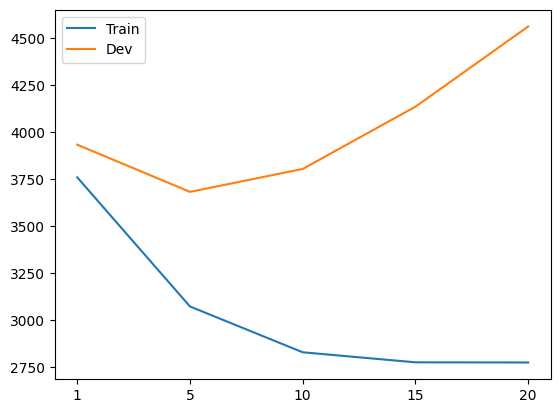

In [ ]:
# Plot the perplexity of each topic model
ks = [1, 5, 10, 15, 20]
train_scores, dev_scores = test_models(M, ks)
plt.plot(np.arange(len(train_scores)), train_scores, label="Train")
plt.plot(np.arange(len(dev_scores)), dev_scores, label="Dev")
plt.xticks(np.arange(len(ks)), ['%d'%k for k in ks])
plt.legend()
plt.show()

# Part 3: Visualization

Now, for the exciting part! Let's use the topic model you just trained to inspect the data visually.

First, Let's train the model with the amount of topics that minimized perplexity above...

In [ ]:
# TODO: Train the model on the full data using the number of topics you chose above (i.e., the value of k that minimized perplexity on dev).

best_k = 5 # ??? # The number of Topics that got the best perplexity
topic_model = train_topic_model(M, best_k) # ??? # Train the topic model with best_k topics
topics = preview_topics(topic_model, idx2word)

To start, we want to visualize our Term Document Matrix, but that can be difficult to visualize because each document is represented by a 5000 component vector. Thus in order to visualize our Matrix, we will want to use **dimensionality reduction** to reduce the number of components to 2 so that we can plot each Document on a 2D grid.  

In the cell below, we'll make use of PCA (Principle Component Analysis), a process that uses SVD (Singular Value Decomposition) to extract out the 2 most important Principal Components of our data which we can use to visualize our Matrix. You will NOT need to code this process from scratch, instead we'll make use of `sklearn.decomposition.PCA` to do it for you.

- The output of `PCA.fit_transform()` is a matrix of shape `(n_samples, n_components)`, where `n_samples = #documents`, and `n_components = 2`, in our case. We will treat each row `i` of the output as 2D coordinates for document `i`.
- Check out the PCA documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# NOTE: This code initialized our PCA model to project our matrix M into 2 dimensions
def pca_projection(M : np.ndarray[np.float64], n_components : int = 2) -> np.ndarray[np.float64]:
  """
  Use PCA to project M into n_components.
  Note: You do NOT need to code this function.

  Parameters
  ----------
  M : np.ndarray[float]
    The input Term Document Matrix
  n_components : int
    The number of components/dimensions that you want to reduce to

  Returns
  -------
  proj : np.ndarray[float]
    The projected matrix (M projected to n_components)
  """
  pca = PCA(n_components) # PCA model with n_components = 2
  proj = pca.fit_transform(M) # Projections: An np.array of shape (n_samples, n_components)
  return proj


With this projection we can now plot all of the documents on a 2d plane, but ideally we want each point to be colored by their "most prominent Topic" and contain some more identifying data about the document.

TODO: In order to achieve this, for each point lets create a function to build a dataframe **df** such that
1. Each row corresponds to one of the documents
2. The **topic** column maps each Document to it's "Most Prominent Topic"
3. The **text** column maps each Document to the a quick text snippet from the Document (the first 100 characters of the Document's raw text)
4. The **x** and **y** columns map to the (x, y) coordinates of the 2d projection

To help you start we have created an empty dataframe with the columns defined in but with no data. Please fill in this dataframe with information from **docs**.


In [ ]:
def generate_datapoints(docs : List[spacy.tokens.Doc], proj: np.ndarray[np.float64], M : np.ndarray[np.float64], topic_model: LatentDirichletAllocation) -> pd.DataFrame:
  """
  Generates a Pandas Dataframe where each row corresponds to the data point (document). Specifically:
    1. The (x, y) coordinates of the projected document
    2. The text of the document (capped at 100 characters)
    3. The most prominent topic of the document (As a string of the topic number e.g. "2")
  An empty Dataframe with the required columns is already set up for you. Please fill it in and return it.
  To help, the related topic_scores and projections for each document are already calculated for you!

  Parameters
  ----------
  docs : List[Doc]
    A list of spacy preprocessed documents
  M : np.ndarray[float]
    The input Term Document Matrix
  proj: np.ndarray[float]
    The projection matrix which is M projected to 2d space using our previously defined pca_projection function
  topic_model: LatentDirichletAllocation
    The trained topic model

  Returns
  -------
  df : DataFrame
    The filled out Dataframe
  """
  df = pd.DataFrame(columns = ['topic', 'text', 'x', 'y'])

  # HINT: To help you find the "Most Prominent Topic" for each document, we can use our topic model to transform M so that
  #       we get a matrix of shape (num_documents, num_topic), where each entry is the "Prominence" score of that topic for that document.
  # Calculate the most prominent topic for each document
  topic_scores = topic_model.transform(M)
  most_prominent_topics = np.argmax(topic_scores, axis=1)
  # Create a list of dictionaries to store data for each document
  doc_data_list = []

  # TODO: Fill out the dataframe with all of the columns filled out for each document (row).
  #       You're free to implement this however you wish (please see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
  #       However it might be easiest to first create a list of dictionaries and then call the pd.DataFrame constructor on the list
  for index, doc in enumerate(docs):
      # Extract the (x, y) coordinates from the projection matrix
      x, y = proj[index]

      # Get the most prominent topic as a string
      most_prominent_topic = str(most_prominent_topics[index])

      # Extract the first 100 characters of the document's raw text as text snippet
      text = doc.text[:100]

      # Create a dictionary for the current document and append it to the DataFrame
      doc_data = {'topic': most_prominent_topic, 'text': text, 'x': x, 'y': y}
      # Append the document data to the list
      doc_data_list.append(doc_data)

  # Concatenate the list of dictionaries into a DataFrame
  df = pd.concat([df, pd.DataFrame(doc_data_list)], ignore_index=True)

  return df

Now, run the following cell to plot the PCA projection of our documents onto 2D! Each point corresponds to a document, which you can hover over and view some of the contents of!

In [ ]:
# This plots the plot_data list built in the previous cell, nothing to do here
df = generate_datapoints(spacy_processed_docs, pca_projection(M, 2), M, topic_model)
fig = px.scatter(df, x="x", y="y", color="topic", hover_data=['text'])
fig.show()

## Geographical Visualization

Now, we'd like you to visualize the most popular topics based on geographical location!

We'll start with a simple bar graph showing the popularity of topics by state, where the height of each bar is the proportion of documents from each location that correspond to a particular topic.

As a warning, these counts of documents are unnormalized... Because of this, states that have a lot of documents may more regularly appear at the front of the bar charts. These charts don't indicate which topics are proportionally popular by state, despite it being more intuitive.

To visualize the most popular counts by location and topic we first need to group and count the number of documents that have that "most prominent topic" and who originate from that location.

TODO: Please fill in the `generate_location_data` function which takes in a list of locations and documents and creates a Dictionary that maps each topic to a Dictionary of {Location : Count}

In [ ]:
def generate_location_data(docs : List[spacy.tokens.Doc], M : np.ndarray[np.float64], locations : List[str], topic_model: LatentDirichletAllocation) -> Dict[int, Dict[str, int]]:
  """
  Aggregates the Documents that all share the same "Most Prominent Topic" and retains a count of the number of Documents at each location
  for each Document. This will be used to generate a Bar Chart visualization and Map Visualization of where each Topic is most popular.

  Parameters
  ----------
  docs : List[Doc]
    A list of spacy preprocessed documents
  M : np.ndarray[float]
    The input Term Document Matrix
  locations : List[str]
    A list that records the location of each document. Thus, the location of i-th document is doc_locations[i]
  topic_model: LatentDirichletAllocation
    The trained topic model

  Returns
  -------
  location_count : Dict[int, Dict[str, int]]
    A dictionary that maps each topic (int) to a Dictionary mapping Location (str) to Counts (int) for that topic.
    This is designed so that
      * location_count[topic][state] is the count of documents for that state and topic
  """
  location_count = {}

  # HINT: To help you find the "Most Prominent Topic" for each document, we can use our topic model to transform M so that
  #       we get a matrix of shape (num_documents, num_topic), where each entry is the "Prominence" score of that topic for that document.
  topic_scores = topic_model.transform(M)

  # Hint: It may be helpful to first create a dictionary mapping Topics (int) to a List of Locations
  #       of the documents who have the Topic as it's "Most Prominent Topic"
  # Loop through each document
  for i, doc in enumerate(docs):
      # Get the most prominent topic for this document
      most_prominent_topic = np.argmax(topic_scores[i])

      # Get the location for this document
      location = locations[i]

      # Create the location_count dictionary if it doesn't exist for this topic
      if most_prominent_topic not in location_count:
          location_count[most_prominent_topic] = {}

      # Update the count for this location and topic
      if location in location_count[most_prominent_topic]:
          location_count[most_prominent_topic][location] += 1
      else:
          location_count[most_prominent_topic][location] = 1

  return location_count


With this, we can use the `generate_location_data` function to aggregate the number of locations for each topic and then generate our Bar Graphs. Nothing more needs to be done here.

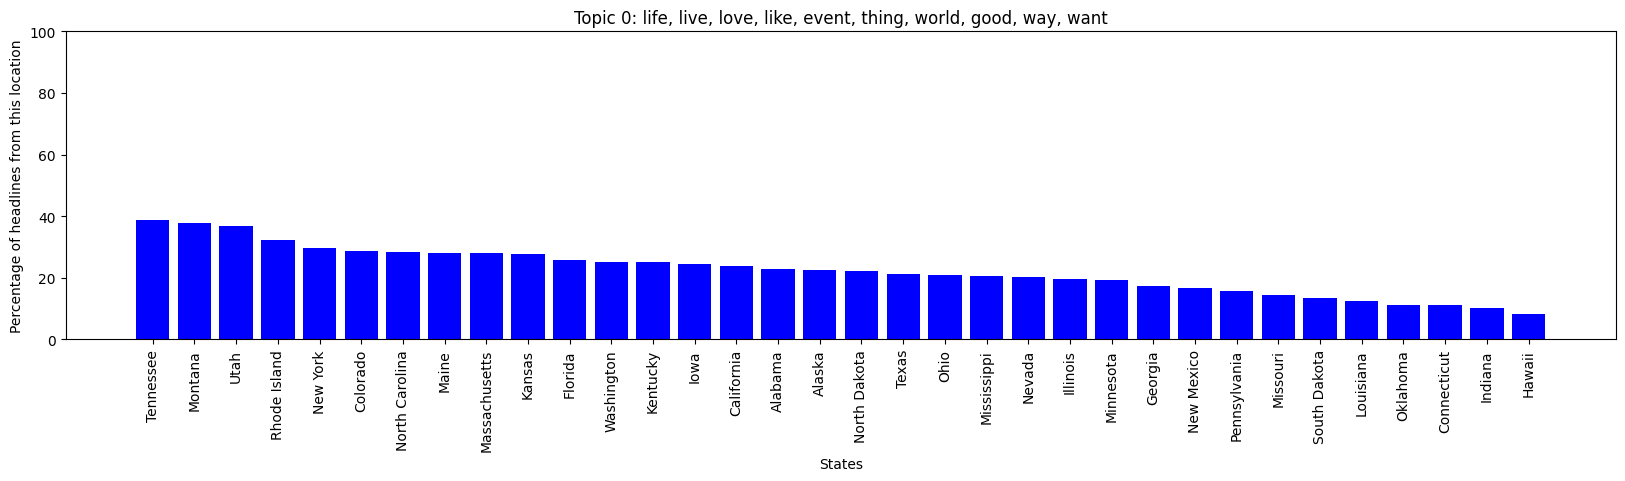

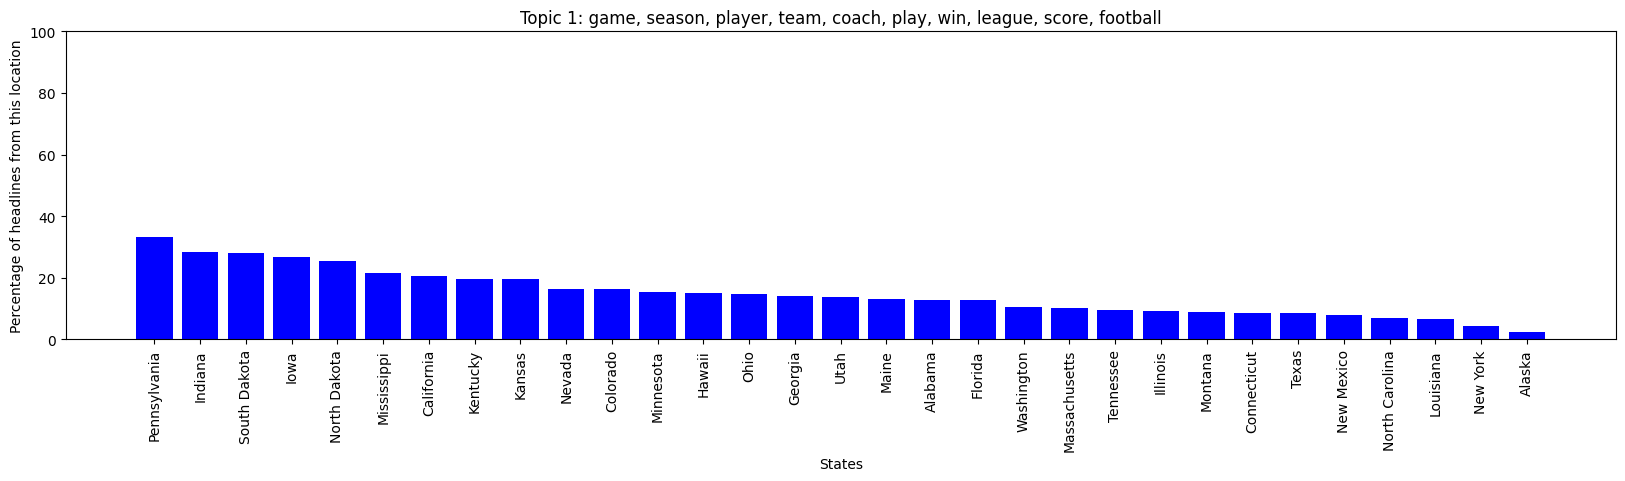

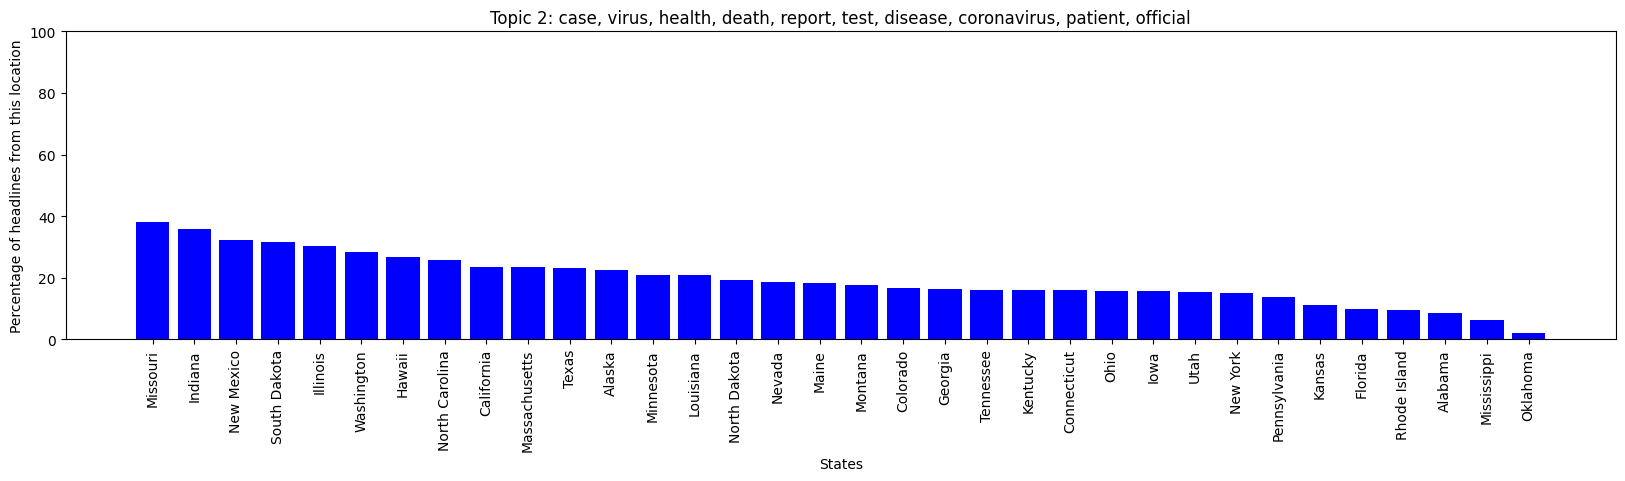

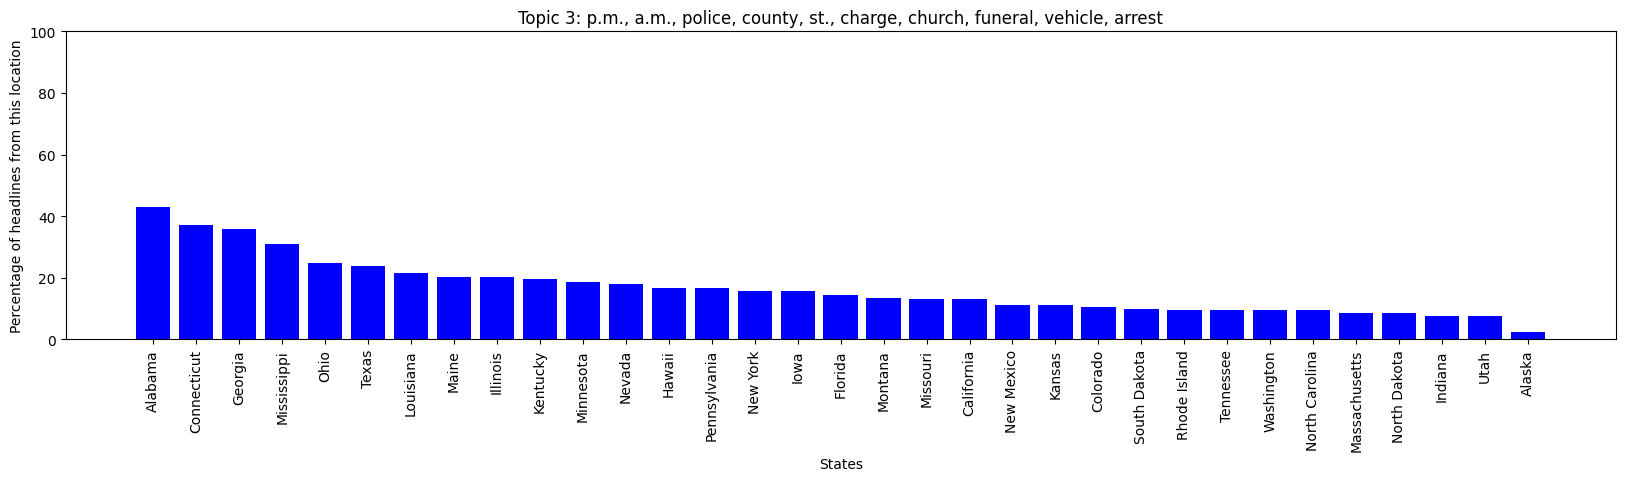

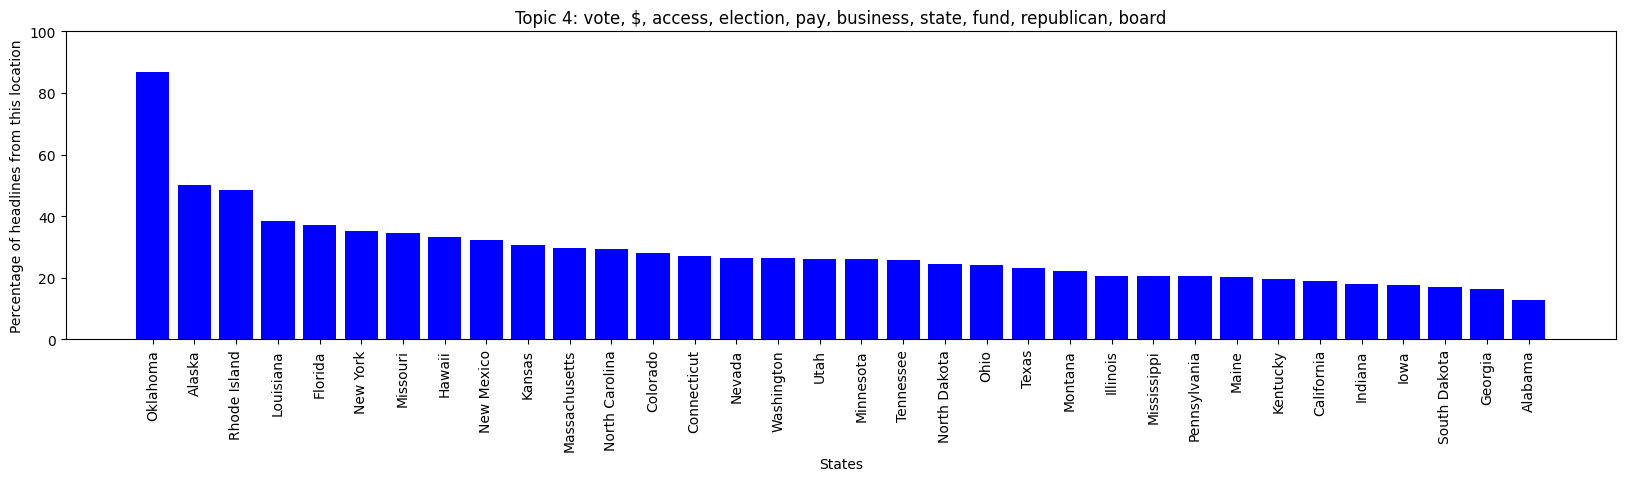

In [ ]:
from collections import Counter

state_count = generate_location_data(spacy_processed_docs, M, doc_locations, topic_model)

# This code makes a bar graph displaying the popularity (as a proportion) per state...
for k in range(best_k):
  fig = plt.figure(figsize=(20,4))

  threshold = 30

  total_doc_counts = dict(Counter(doc_locations).items())
  normalized_state_count = {loc : 100 * state_count[k][loc] / total_doc_counts[loc] for loc in state_count[k] if total_doc_counts[loc] > threshold}
  state_items = sorted(normalized_state_count.items(), key = lambda item: item[1], reverse = True)
  state_names = [item[0] for item in state_items]
  count = np.array([item[1] for item in state_items])

  plt.bar(state_names, count, color ='blue', width = .8)
  plt.ylim([0, 100])
  plt.xticks(rotation=90)
  plt.xlabel("States")
  plt.ylabel("Percentage of headlines from this location")
  plt.title(f"Topic {k}: {', '.join(topics[k])}")
  plt.show()

Now, we'll use a library to plot the number of documents of each topic on a map, because it's much more visually intuitive than a bar graph!

In [ ]:
from geopy.geocoders import Nominatim
import plotly.graph_objects as go

# Our geolocation service
geolocator = Nominatim(user_agent='myapplication')
for k in range(best_k):
  lon, lat = [], []

  threshold = 30

  total_doc_counts = dict(Counter(doc_locations).items())
  normalized_state_count = {loc : 100 * state_count[k][loc] / total_doc_counts[loc] for loc in state_count[k] if total_doc_counts[loc] > threshold}
  state_items = sorted(normalized_state_count.items(), key = lambda item: item[1], reverse = True)
  state_names = [item[0] for item in state_items]
  count = np.array([item[1] for item in state_items])

  labels = []
  # Assign each state a geographical location
  for state, c in zip(state_names, count):
    location = geolocator.geocode(state)
    lat.append(location.latitude)
    lon.append(location.longitude)
    labels.append(f"{state} : {c}% of all {state} headlines have this topic")

  marker = dict(color="blue", size=count)
  fig = go.Figure(data=go.Scattergeo(lon=lon, lat=lat, text=labels, mode='markers', marker=marker))
  fig.update_layout(title = f"Topic {k}: {', '.join(topics[k])}" ,geo_scope='usa')
  fig.show()

## 4. Conceptual Questions

In this section, you may need to write more code to answer the conceptual questions—much of which will draw from code you've already written above. Do *not* change any code you've already written above; make duplicates in this section to edit, if necessary. Create markdown cells for written responses.

### Question 1: Threshold?
When we plotted the bar graphs and geographical graphs, we included a line `threshold=30` to exclude some states.
Create code cell(s) below to re-create the bar graphs with the same topic model without excluding any states. Which topics now have different top states? Using one of these topics and its new top state as an example, why was the threshold necessary?

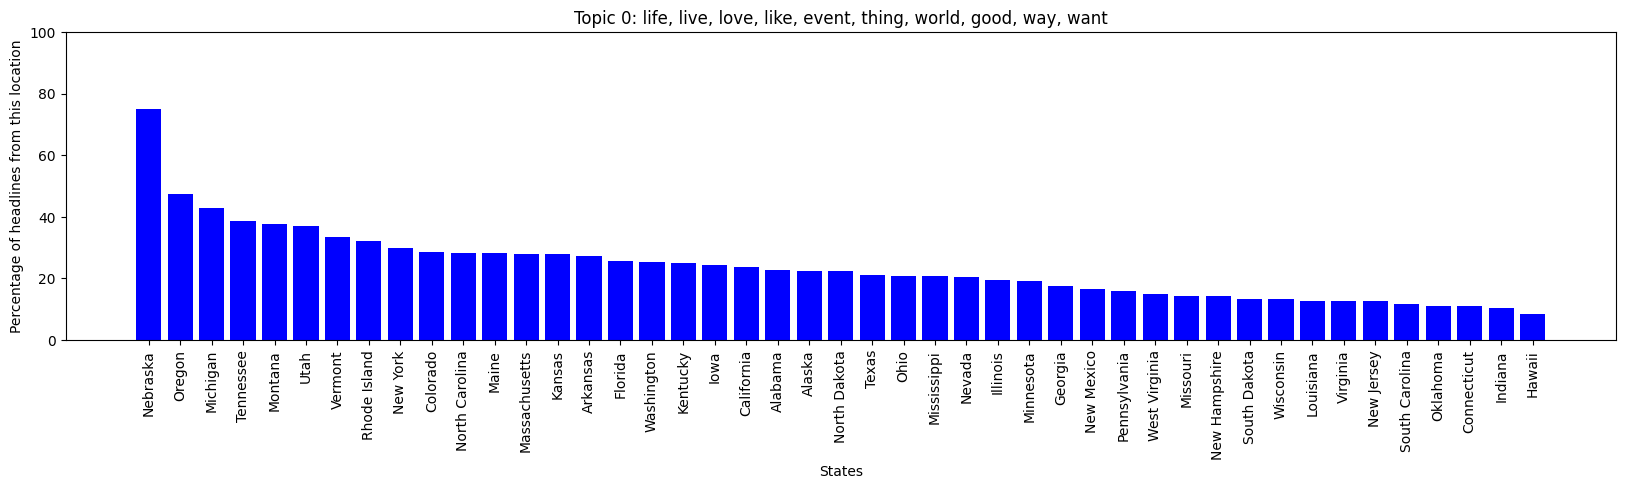

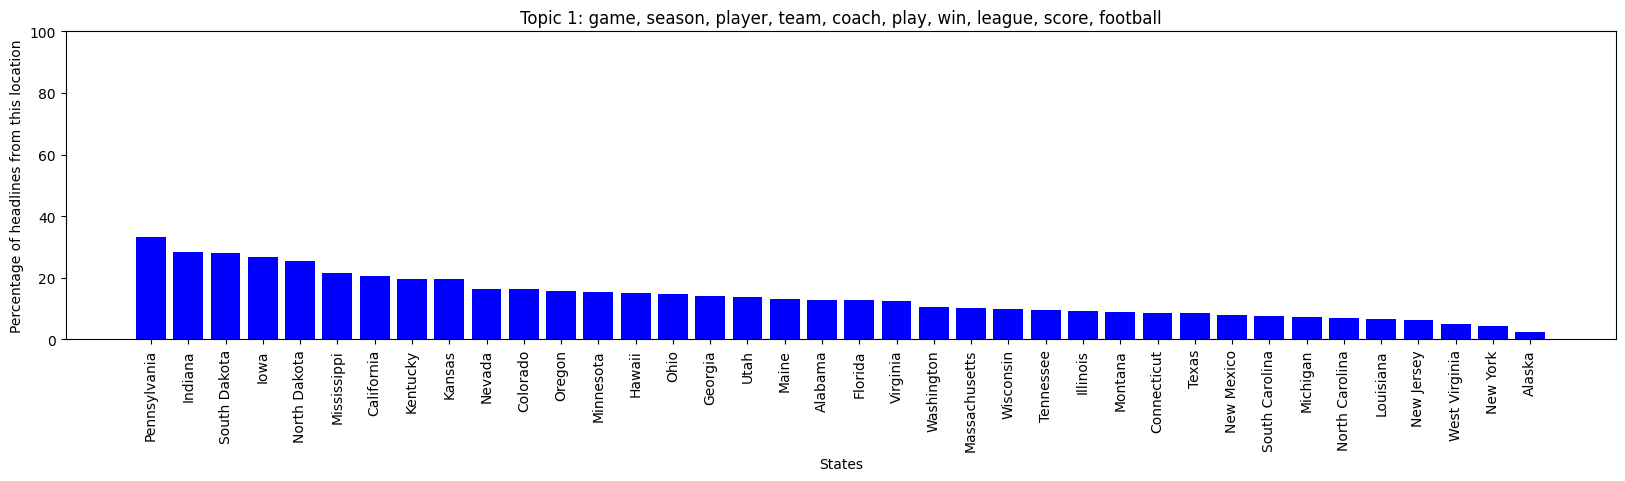

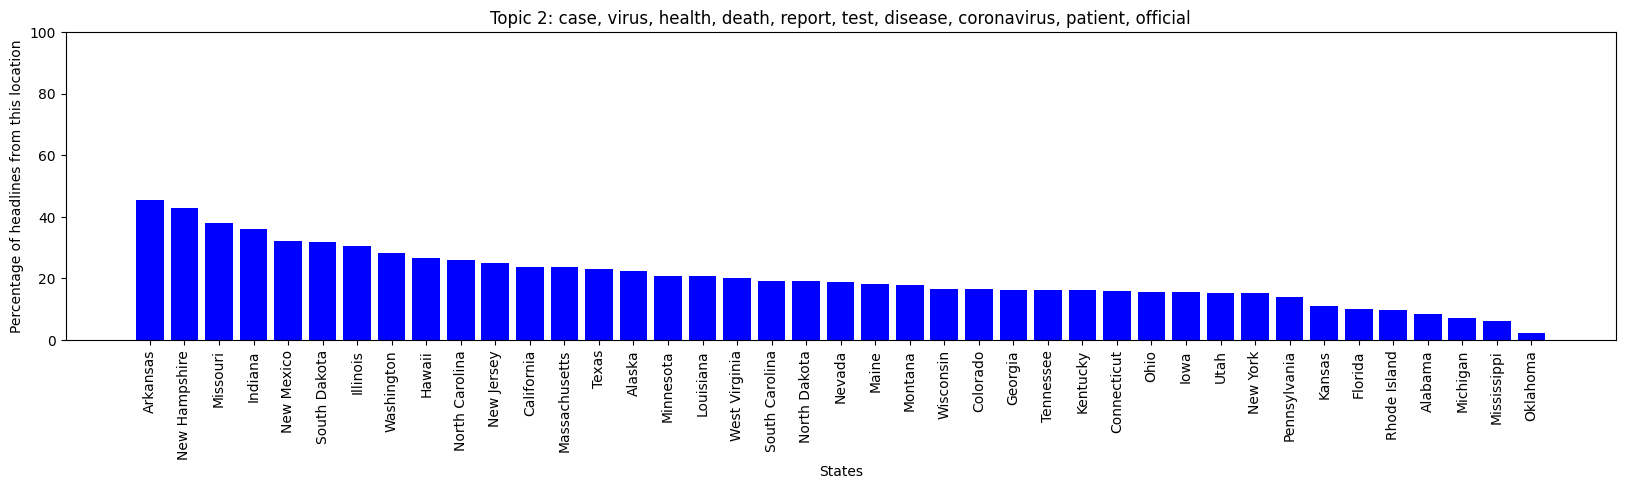

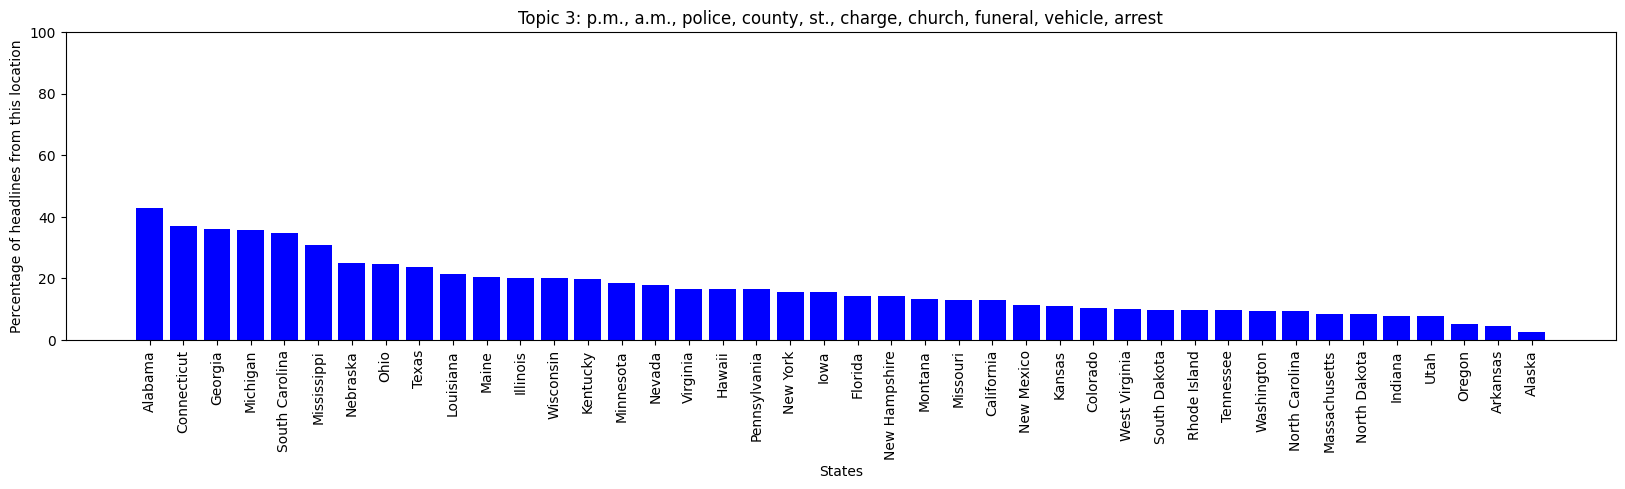

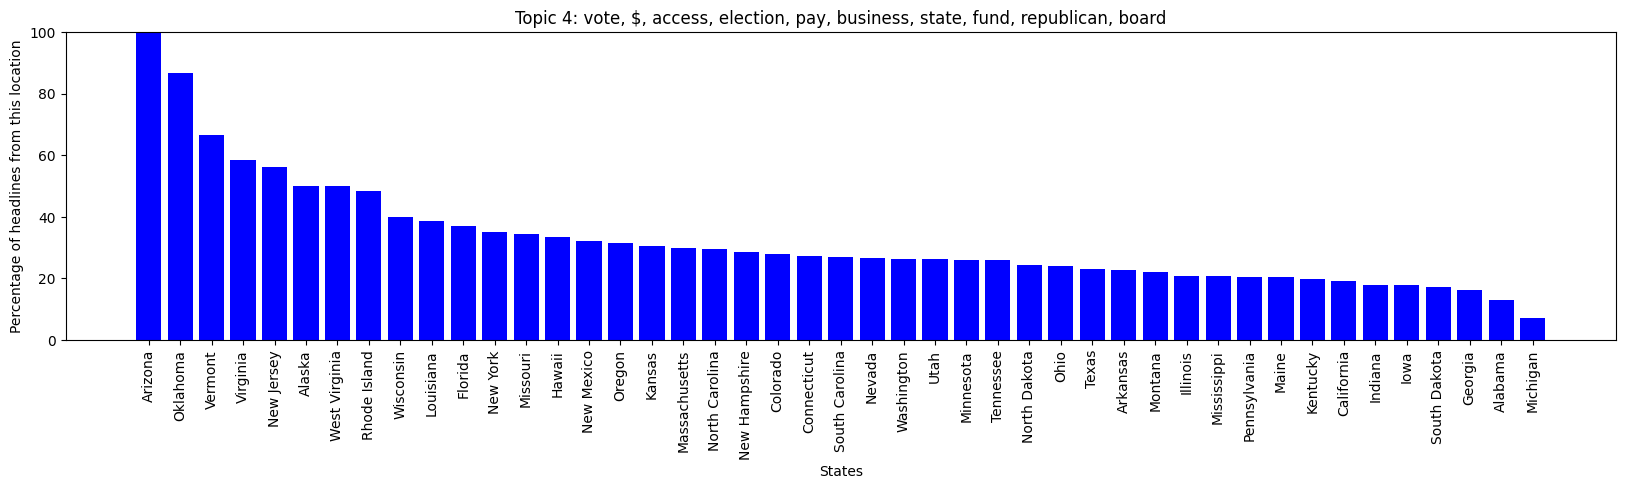

In [ ]:
from collections import Counter

state_count = generate_location_data(spacy_processed_docs, M, doc_locations, topic_model)
for k in range(best_k):
  fig = plt.figure(figsize=(20,4))

  threshold = 0
  total_doc_counts = dict(Counter(doc_locations).items())
  normalized_state_count = {loc : 100 * state_count[k][loc] / total_doc_counts[loc] for loc in state_count[k] if total_doc_counts[loc] > threshold}
  state_items = sorted(normalized_state_count.items(), key = lambda item: item[1], reverse = True)
  state_names = [item[0] for item in state_items]
  count = np.array([item[1] for item in state_items])

  plt.bar(state_names, count, color ='blue', width = .8)
  plt.ylim([0, 100])
  plt.xticks(rotation=90)
  plt.xlabel("States")
  plt.ylabel("Percentage of headlines from this location")
  plt.title(f"Topic {k}: {', '.join(topics[k])}")
  plt.show()

ANSWER: The threshold helps filter out noise and improves analysis accuracy. For example, the initial analysis showed Oklahoma as the top state for Topic 4 due to a higher threshold that excluded states with fewer documents. Lowering the threshold to zero and including all states revealed Arizona as the top state for Topic 4. This change might be because Arizona had more documents related to Topic 4. Using a higher threshold simplifies the chart and makes it easier to understand. Without the threshold, some documents may have very few states associated with them. For instance, a document with only one state might falsely indicate that the state appears in that document with 100% occurrence. By excluding states with a threshold, we mitigate this issue and ensure that states in the analysis are associated with a more meaningful number of documents.

### Question 2: Perplexed on Perplexity
We asked you to plot a perplexity graph to choose the number of topics that minimizes perplexity on held-out data. Please answer the following questions:
- What is perplexity in the context of our topic model?
- Why does perplexity not necessarily decrease by increasing the number of topics?

ANSWER:
- In our model, the perplextiy is a measurement of how well the model predicts or explains a dataset of documents. It shows how well a model is when predicting the words in unseen or new documents based on the topics it has learned from the training data. A lower perplexity score indicates that the model is better at explaining the held-out data, as the model's predictions closely match the actual words in the unseen documents.
- As we increase the number of topics, the model becomes more complex and can start fitting to noise in the training data. This may cause overfitting that the model fail to capture the underlying structure of topics, which may also lead to a poor generalization to unseen data. The model loses its ability to make accurate predictions on new data, resulting in high perplexity scores. Also, the available data for estimating the parameters of each topic decreases. This can lead to less accurate estimations of topic to word distributions and document to topic distributions.



# Submission Instructions
Please submit this Colab as **two** files to Gradescope:
1.   A `.py` file: Click File > Download > Download .py
2.   A `.ipynb` file ***WITH OUTPUTS***: Click Runtime > Run All, and then after all outputs are complete, click File > Download > Download .ipynb

Please ensure that the `.ipynb` contains actual function outputs (and not leftover print statements, for instance). We will run your `.ipynb` file; if our outputs don't match the outputs in your submitted file (within reason), you will receive a 0 on this assignment.

Please also keep any helper functions that you create for your implementation on the same cell and keep the cells to the function definition and print statements that we provided ONLY for best Autograder results. Thank you!